# NBA referees analysis: endgame accuracy

This notebook is concerned with estimating the accuracy of NBA referees in the last 2 minutes of a game. In more detail, we estimate the standard deviation of the probability $p_k$ of a referee $k$ making a correct call (given that a call was made). In particular we try to estimate how this uncertainty varies with the referee's experience.  As the accuracy of a NBA referee in the end of a game is of extreme importance in determining the winning team,  league managers will consider this feature when taking decisions about referee's salary  and game matching. Therefore, an accurate estimate of this uncertanty can  be a usefull tool for managers's decision making.

This notebook was inspired by Austin Rochford's [NBA Foul Calls and Bayesian Item Response Theory](https://www.austinrochford.com/posts/2017-04-04-nba-irt.html).

## Data

We extend a [data set](https://github.com/polygraph-cool/last-two-minute-report) derived from the NBA's [Last Two Minute Report](http://official.nba.com/nba-last-two-minute-reports-archive/) by [Russell Goldenberg](http://russellgoldenberg.com/), which includes a collection of reviewied of calls and non calls in the seasons '2015-2016', '2016-2017' and '2017-2018'. In particular we add information and classification of referee's experience.


## Research questions
Let $p_k$ be the probability that a referee $k$ makes a correct call given that $k$ made a call in the last 2 minutes of the game. By referee experience for $k$ we mean the years $k$ has been actively refereeing (by 2021). We then say that $k$ is Junior, Mid or Senior according to whether $k$ has less than 10, between 10 and 20 or more than 20 years experience, respectively. Our questions:

1) What is the standard deviation of each $p_k$?

2) What is the standard deviation of all $p_k$ due to $k$ being either Junior (less than 10 years experience), Mid (between 10 and 20 years experience) and Senior (more than 20 years experience) referees?

3) What is a good classification in terms of referee experience to classify engame precision?


## Methodology
The analysis is carried out with several Bayesian models: 
- a vanilla unpooled beta-Bernoulli model (1),
- a hiherchical beta-Bernoulli model (1,2),
- a vanilla unpooled logit model (1),
- a hiherchical logit model (1,2,3),
- a partially pooled logit model (1,2,3),
- a log-odds ratio with linear estimation of experience impact (3).

Our models a solved using [PyMC3](https://docs.pymc.io/).

## Conclusions and comments 
Our main conclusion is that there is a significant difference in precision between referees with less than 10 years experience and more than 10 years experience, meanwhile Mid and Senior referees perform similarly.


### Data issues 
- Lack of data on the referee that made the call.
- Referees selection.
- Other variables that might be taken into account...
- Tighter prior/posteriors plt and convergence checks
- Use a loss function with respect to th...
- Other approaches.
- Comment on model check.
- Assuming each referee calls/noncalls independently of other referees.
- Extend to item response to see referees behaving better with home team being behind

# Data collection and cleaning
We first import the data and remove calls from quarters before the 4th and a referee with missing data. The data is also available in the folder and can be imported with 

`orig_df = pd.read_csv('/data/all_games.csv')`

In [1]:
import pandas as pd
import numpy as np
import pymc3 as pm
import matplotlib.pyplot as plt
import datetime
import seaborn as sns
import arviz as az
import theano.tensor as tt
plt.style.use('seaborn')
%matplotlib inline

In [2]:
%%bash
DATA_URI=https://raw.githubusercontent.com/polygraph-cool/last-two-minute-report/32f1c43dfa06c2e7652cc51ea65758007f2a1a01/output/all_games.csv
DATA_DEST=/tmp/all_games.csv

if [[ ! -e $DATA_DEST ]];
then
    wget -q -O $DATA_DEST $DATA_URI
fi

In [5]:
orig_df = pd.read_csv(
    '/tmp/all_games.csv',
    index_col='play_id',
    parse_dates=['date']
)

In [10]:
orig_df = pd.read_csv('./data/all_games.csv')

In [11]:
#orig_df.to_csv('file.csv')
USECOLS = [
    'period',
    'seconds_left',
    'call_type',   
    'review_decision',
    'ref_1',
    'date',
    'disadvantaged_team',
    'committing_team'
]
df = orig_df[USECOLS].dropna(axis=0)
df = df.loc[df.ref_1 != 'Violet Palmer']
df = df.loc[(df.period != 'Q1') & (df.period != 'Q2') & (df.period != 'Q3')]

We add four colunms: season,  the first referee id, referee experience (in years) and referee experience class as:
- 0: 0-10 years experience by 2021 (Junior)
- 1: 11-20 years experience by 2021 (Mid)
- 2: 21+ years experience by 2021 (Senior)

In [12]:
########################
#Add referee ID

ref_lis = list(set(df.ref_1))
ref_lis.sort()
years_exp = []
for ref in ref_lis:
    ID = ref.split(' ')[1:][0][0:5] +ref[0:2]+'99r'
    #print(ID)
    try:
      df_re = pd.read_html(f'https://www.basketball-reference.com/referees/{ID.lower()}.html')
      #print(df_re)
      first, last = (df_re[0][[('Unnamed: 0_level_0', 'Season')]].iloc[0,:][0],
                     df_re[0][[('Unnamed: 0_level_0', 'Season')]].iloc[-2,:][0])
      first, last = int(first[0:4]), int(last[0:4])
      #print(last-first)
      years_exp.append(last-first)
    except:
      print(f'Url not found for {ref}.')
      years_exp.append(None)        
def ref_exper(ref):
    idx = ref_lis.index(ref)
    return years_exp[idx]
df = df.assign(ref_exp=lambda df: df['ref_1'].apply(ref_exper))

########################
#Add referee experience (Junior = 10, Mid = 20, Senior = 30)

def exp_year_cls(ref_exp):
    try: 
       ref_exp = int(ref_exp) 
       if ref_exp >= 20:
        return 2
       elif ref_exp >= 10:
        return 1
       elif ref_exp >= 0:
        return 0   
    except:
        return None       
df = df.assign(ref_exp_cls=lambda df: df['ref_exp'].apply(exp_year_cls))
df = df.dropna()#loc[df.ref_exp_cls != None]
ref_lis = list(set(df.ref_1))
ref_lis.sort()

Url not found for J.T. Orr.


We now  plot all calls and non-calls. Then we
- remove non-calls from our data set, 
- number correct calls (CC) by 1 and incorrect calls (IC) by 0,
- index referees, and
- remove calls that happend with more than 120 seconds left on the period's clock.

CNC    8368
CC     4184
INC    1405
IC      165
Name: review_decision, dtype: int64

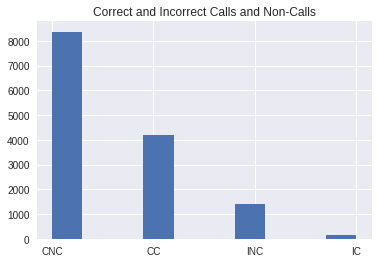

In [13]:
df['review_decision'].hist()
plt.title('Correct and Incorrect Calls and Non-Calls')
df['review_decision'].value_counts()

In [14]:
df_ref_c = df.loc[:,['seconds_left','review_decision','ref_1','ref_exp_cls','ref_exp']]
df_ref_c = df_ref_c.loc[(df_ref_c.review_decision == 'CC')|
                        (df_ref_c.review_decision == 'IC')].loc[df_ref_c.seconds_left<=120]

In [15]:
def call_to_binary(review_decision):
    out = 0
    if review_decision == 'CC':
        out = 1
    return out
df_ref_c = df_ref_c.assign(review_decision_bin=lambda df_ref_c:
                           df_ref_c['review_decision'].apply(call_to_binary))

In [16]:
ref_num = len(set(df_ref_c.ref_1))
ref_list = list(set(df_ref_c.ref_1))
ref_list.sort()
def ref_to_index(ref_1):
    return ref_list.index(ref_1)
df_ref_c = df_ref_c.assign(ref_1_idx=lambda df_ref_c: df_ref_c['ref_1'].apply(ref_to_index))
df_ref_c = df_ref_c[df_ref_c.ref_exp_cls != None]

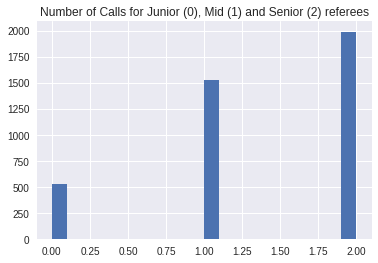

In [17]:
df_ref_c.ref_exp_cls.hist(bins=20)
plt.title('Number of Calls for Junior (0), Mid (1) and Senior (2) referees');

Average correct calls among all calls: 96.47 %


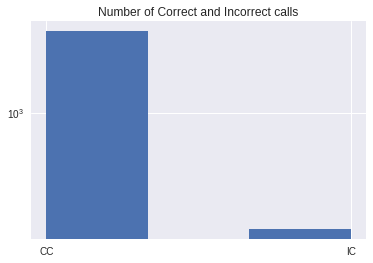

In [18]:
df_ref_c.review_decision.hist(bins=3,log=True)
plt.title('Number of Correct and Incorrect calls');
mu_cc = df_ref_c.review_decision_bin.value_counts()[1]/len(df_ref_c.review_decision_bin)
print('Average correct calls among all calls:', 100*round(mu_cc,4),'%')

In [19]:
ref_lis_exp = [list(set(df_ref_c.loc[df_ref_c.ref_1 == x].ref_exp.values))[0] for x in ref_lis]
ref_lis_calls = [ len(df_ref_c.loc[df_ref_c.ref_1 == x]) for x in ref_lis]
ref_lis_ccalls = np.array([ len(df_ref_c.loc[(df_ref_c.ref_1 == x) &(
                   df_ref_c.review_decision_bin == 1)]) for x in ref_lis])/np.array(ref_lis_calls)
df_ref = pd.DataFrame({'Referee':ref_lis, 'Experience':ref_lis_exp,'Number of calls': ref_lis_calls,
                       '% of correct calls': 100*np.round(ref_lis_ccalls,3)});
df_ref.index.name = 'ID'
print('Expand the table below to see the full list of referees with the respective index.')
df_ref.head(16)

Expand the table below to see the full list of referees with the respective index.


,Referee,Experience,Number of calls,% of correct calls
ID,,,,
0,Bennie Adams,25.0,189,95.2
1,Bill Kennedy,25.0,49,98.0
2,Bill Spooner,31.0,12,100.0
3,Brent Barnaky,11.0,169,98.2
4,Brett Nansel,6.0,2,100.0
5,Brian Forte,13.0,95,96.8
6,Courtney Kirkland,21.0,31,93.5
7,Curtis Blair,12.0,119,95.8
8,Dan Crawford,28.0,141,96.5


Note that there are ten referees with 100% correct calls. This can be an issue for the logit models at the HMC could get stu

# Beta-Bernoulli model

# Vanilla model
Denote by $n+1$ the number of plays with Foul calls,  $c$ the number of correct foul calls, by $r+1$ the number of referees. Indexing referees by $k=0,1,..,r$, we denote by $n_k$ the number of calls made made by referee $k$ and by $c_k$ the number of correct calls made by referee $k$. Let's study a simple Bernoulli trials model to estimate the probability $p_{k}$ where $k$ is a (leading) referee and $k(i)$ is the referee for the call $i\in\{0,1,...,n\}$. The likelihood of (each realisation of) the model is
$$
y_i \sim p_{k(i)}^{[i]}(1-p_{k(i)})^{[i]},
$$
where $[i]=1$ if the $i$-th call is correct and 0 otherwise, and the prior on each $p_{k}$ is $Beta(\alpha,\beta)$ distributed, so that our model is
$$
p(\theta|y)\propto p(y|\theta)p(\theta) =\Big(\prod_{i=0}^n p_{k(i)}^{[i]}(1-p_{k(i)})^{[i]}\Big)\prod_{j=0}^r \binom{n_j}{c_j}\frac{p_{j}^{\alpha-1}(1-p_{j})^{\beta-1}}{B(\alpha, \beta)}.
$$
Although this model is conjugate, we solve it with HMC.

In [15]:
ref_num = len(set(df.ref_1))
idx = df_ref_c.ref_1_idx
observed_calls = df_ref_c.review_decision_bin

with pm.Model() as mod_bern:
    #Prior
    p = pm.Beta('p', alpha =1,beta=1, shape=ref_num)    
    #Likelihood
    y = pm.Bernoulli('y',  p[idx], observed = observed_calls)

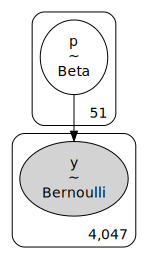

In [77]:
pm.model_to_graphviz(mod_bern)

In [78]:
n_tune = 1000
n_samples = 1000
seed = 2398572
chains =4
def sample(model, n_tune, n_samples, seed, chains):
    with model:
        full_trace = pm.sample(n_tune + n_samples, tune=n_tune, chains=chains, cores=chains, random_seed=seed, return_inferencedata=True, target_accept=.8)
    return full_trace

In [79]:
trace_bern = sample(mod_bern, n_tune, n_samples, seed, chains)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [p]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 12 seconds.


By plotting the trace we can see quite different performances in making a correct call between different referees.

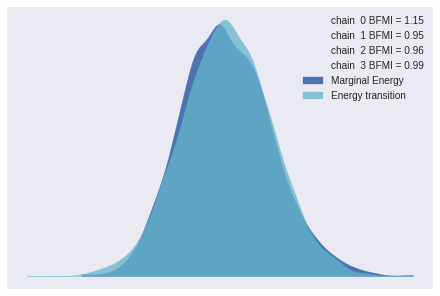

In [19]:
az.plot_energy(trace_bern);

We plot the most traces a forests of the vanilla beta-Bernoulli below.
The estimates are consistent with the data, generally asigning a larger standard deviation to referees with low total calls, like Nansel (id 4) and Roe (id 15) ).


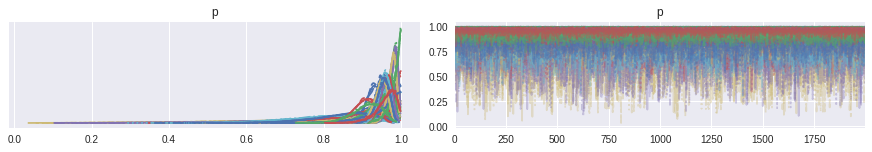

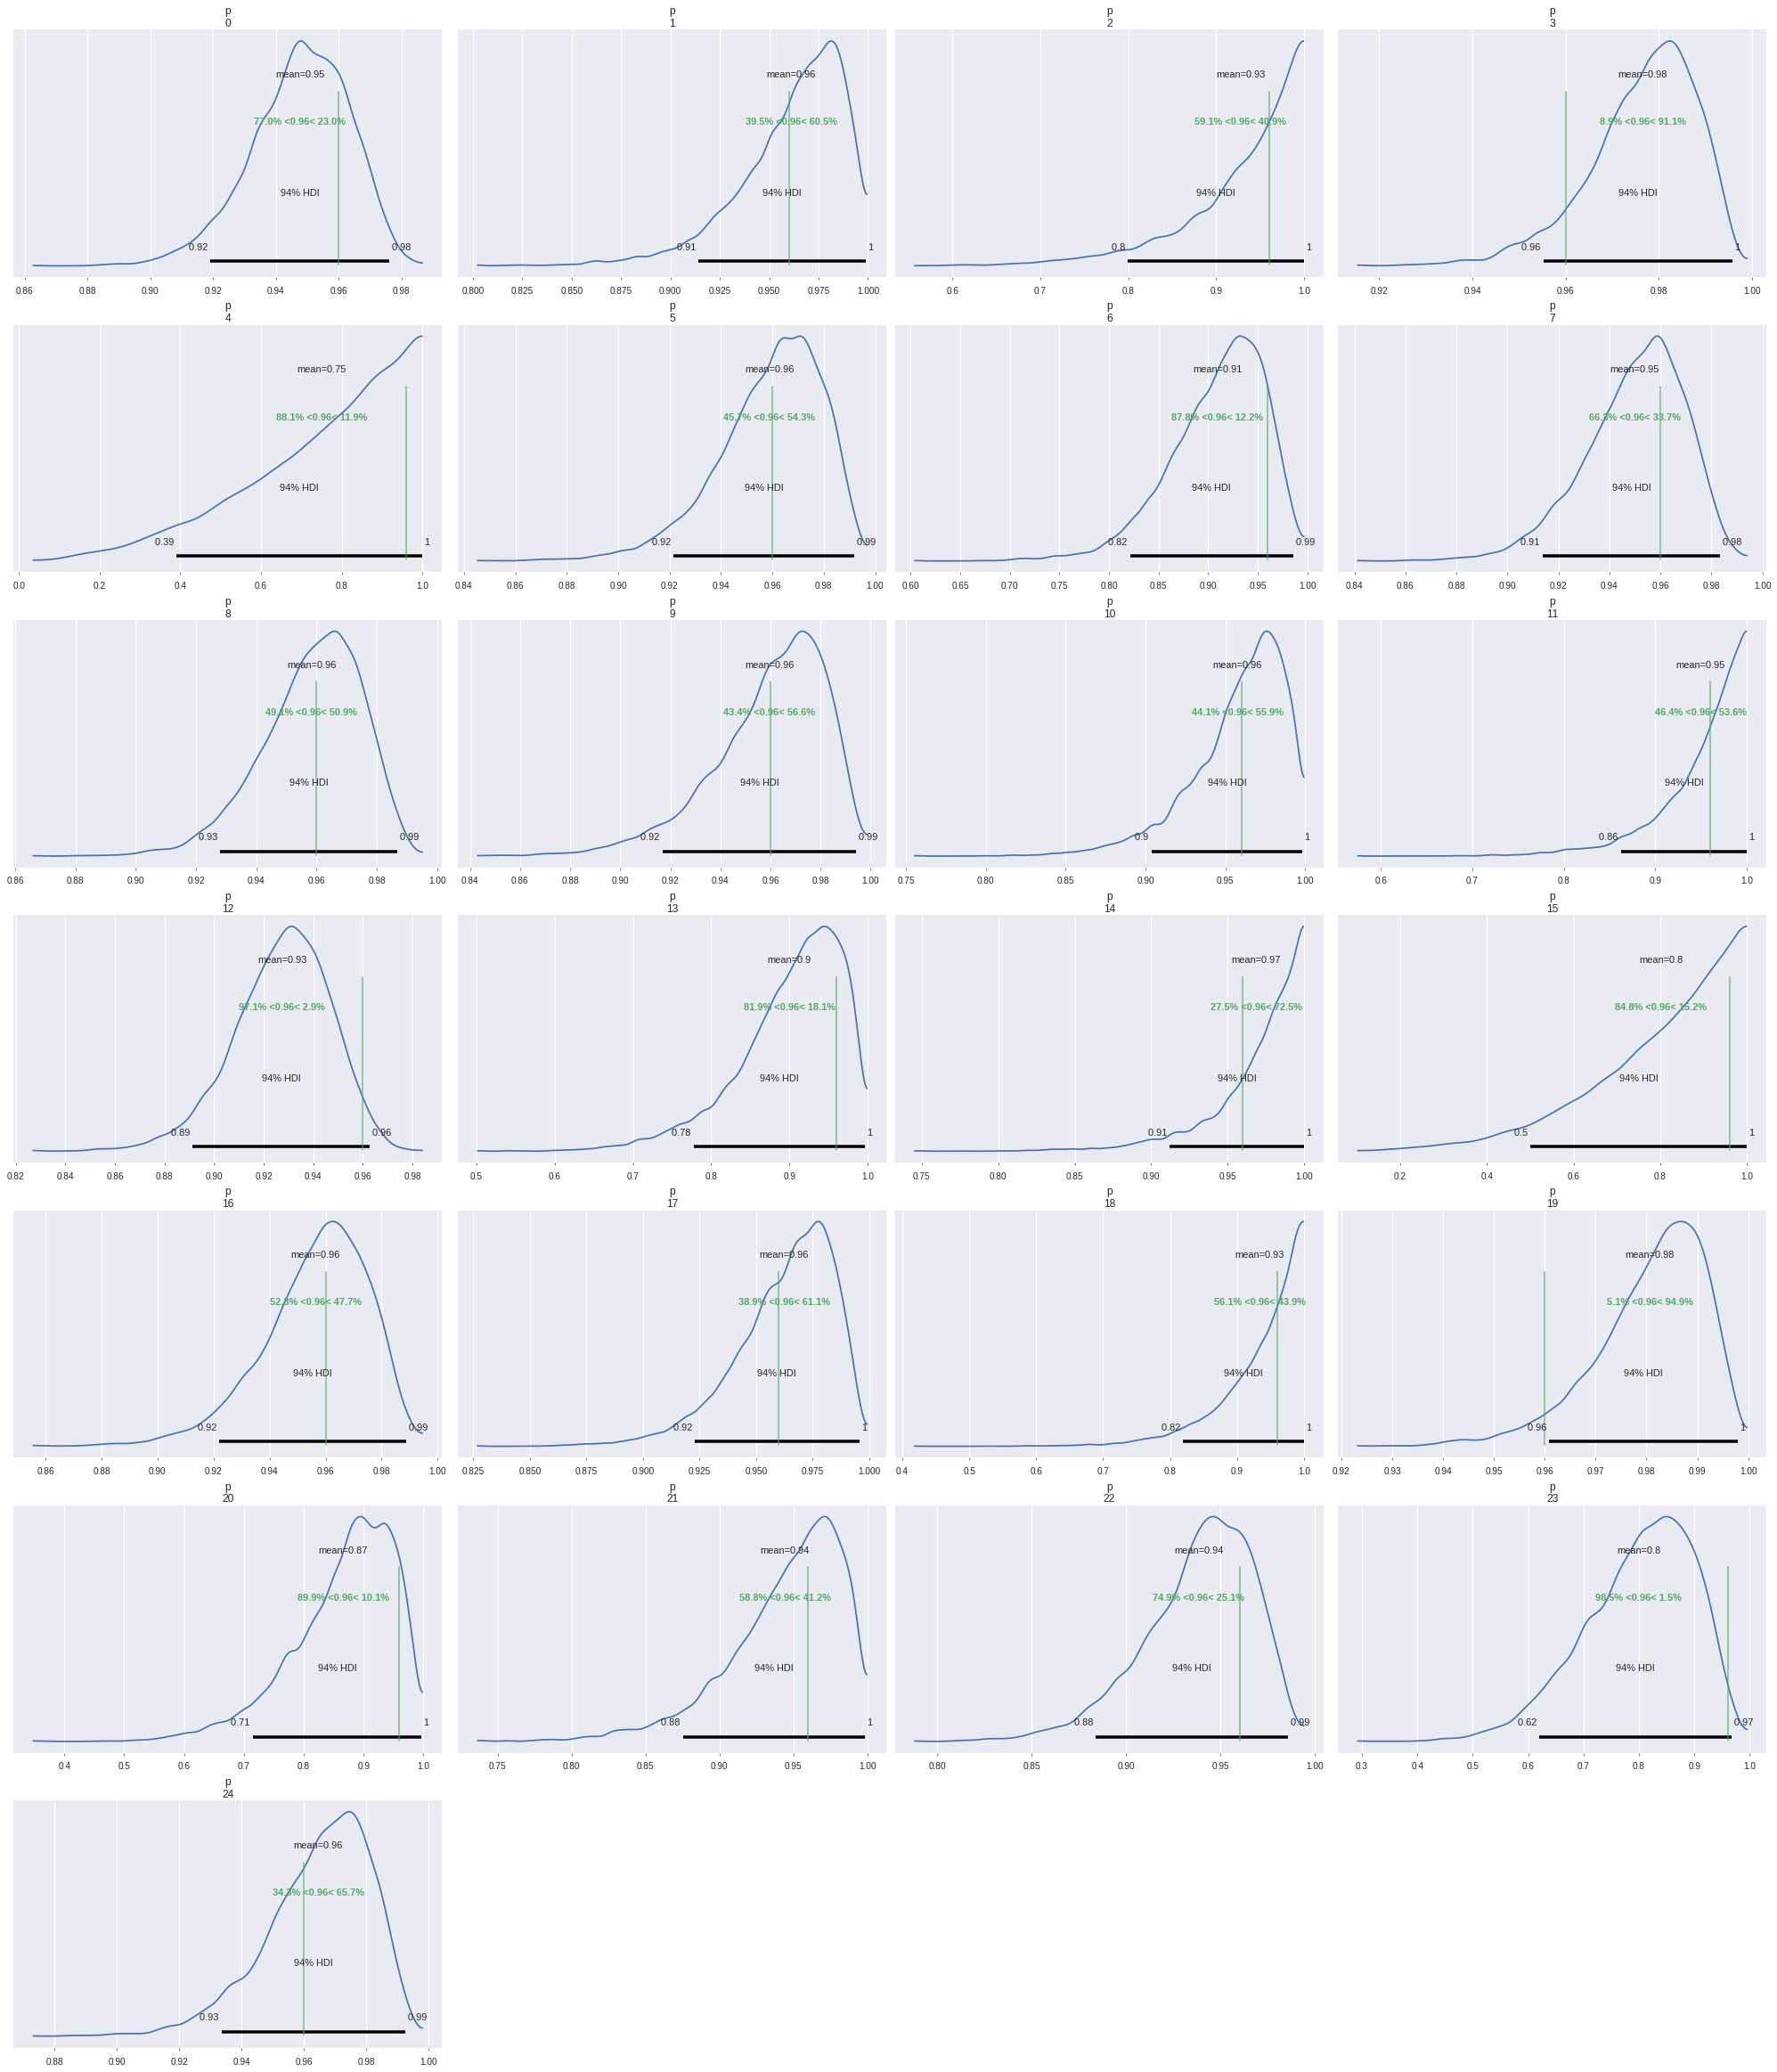

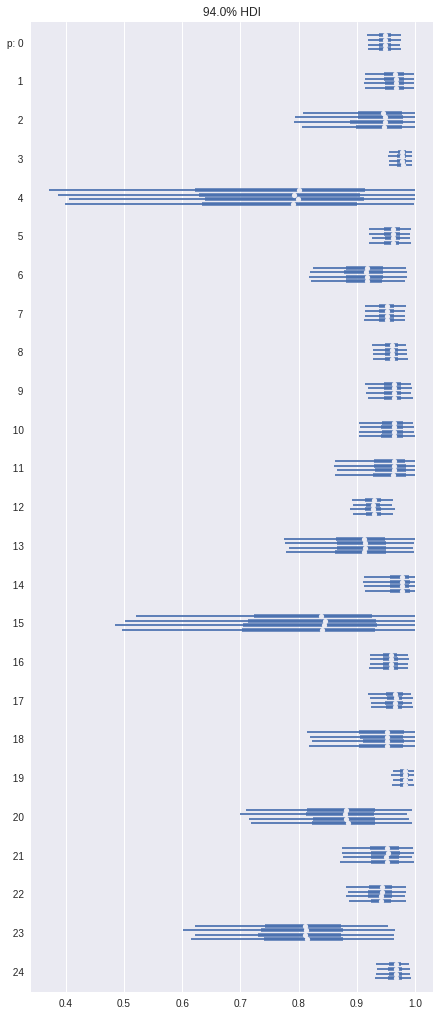

In [87]:
az.plot_trace(trace_bern);
az.plot_posterior(trace_bern.posterior['p'][:,:,0:25], ref_val=.96 );
az.plot_forest(trace_bern.posterior['p'][:,:,0:25]);
print('We plot the most traces a forests of the vanilla beta-Bernoulli below.')
print('The estimates are consistent with the data, generally asigning a larger standard deviation to referees with low total calls, like Nansel (id 4) and Roe (id 15) ).')

In [22]:
with mod_bern:
    prior_checks = pm.sample_prior_predictive(samples=1000)
    ppc = pm.sample_posterior_predictive(trace_bern, samples=chains*(n_tune+n_samples))

## Hierarchical beta-Bernoulli
We now introduce a layer of hierarchy to our beta-Bernoulli model. We do so by assuming that 

$$p_k\sim B(\alpha_{j(k)},\beta_{j(k)})\quad \text{where}\quad \alpha_{j(k)}\sim Uniform[0,40] ,\,\,\, \beta_{j(k)}\sim Uniform[0,5],\,\,\,
$$

and

$$
j(k)=\left\{\begin{split}&0,\quad &\text{if $k$ is Junior},\\
&1,,\quad &\text{if $k$ is Mid},\\
&2,,\quad &\text{if $k$  is Senior}.
\end{split}\right.
$$

The uniform priors are chosen in a range so that $\alpha/(\alpha+\beta)$, the mean of $B(\alpha,\beta)$,  is close to the data set mean (approx 96%).

In [91]:
idx = df_ref_c.ref_1_idx
obs_ref_class = []
for j in range(len(set(idx))):
    try:
     obs_ref_class.append(int(list(set(df_ref_c.ref_exp_cls.loc[df_ref_c.ref_1_idx == j].values))[0]))
    except:
        print(f'Class of {j}-th call not found.')
observed_calls = df_ref_c.review_decision_bin

with pm.Model() as mod_bern_hier:
    #Hyperprior
    alpha = pm.Uniform('alpha', lower=0, upper=40, shape =3)
    beta = pm.Uniform('beta', lower=0, upper=5, shape =3)
    #Prior
    p = pm.Beta('p', alpha=alpha[obs_ref_class], beta=beta[obs_ref_class], shape=len(set(idx)))
    #Likelihood
    y = pm.Bernoulli('y', p[idx], observed=observed_calls)

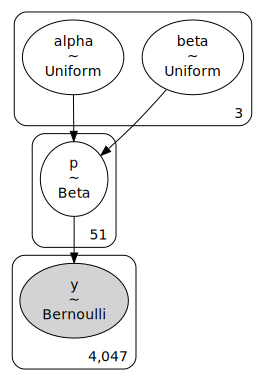

In [92]:
pm.model_to_graphviz(mod_bern_hier)

In [93]:
trace_bern_hier = sample(mod_bern_hier, n_tune, n_samples, seed, chains) 
#seed=43734747 -> 3 warnings, seed=seed or 860789 -> 4 warnings in conda env, o.w. no warning

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [p, beta, alpha]


/home/mas/anaconda3/envs/NBA-referees-analysis/lib/python3.9/site-packages/pymc3/step_methods/hmc/integration.py:108: RuntimeWarning: invalid value encountered in double_scalars
  energy = kinetic - logp
Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 16 seconds.


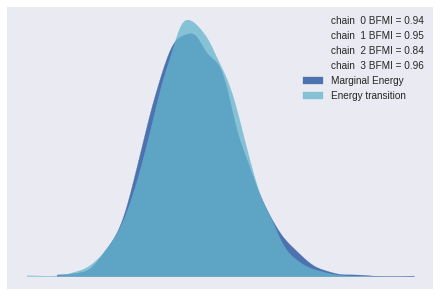

In [28]:
az.plot_energy(trace_bern_hier);

The posteriors of alpha and beta suggest that Junior referees have a lower average and a higher variance.


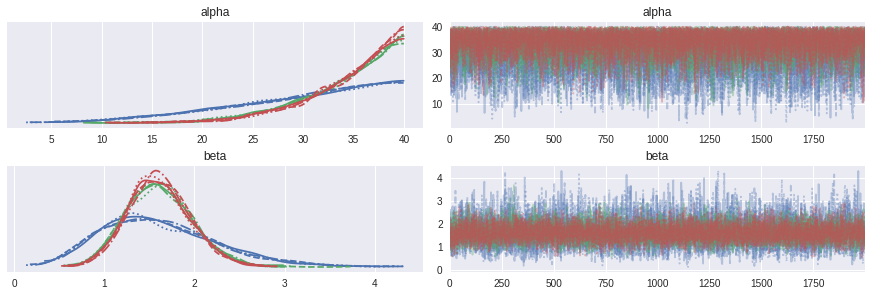

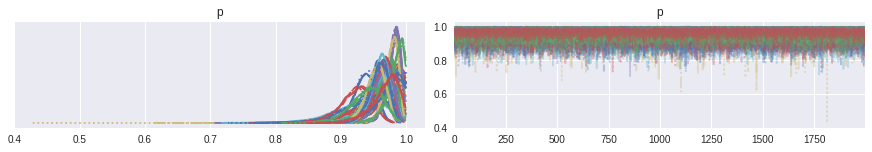

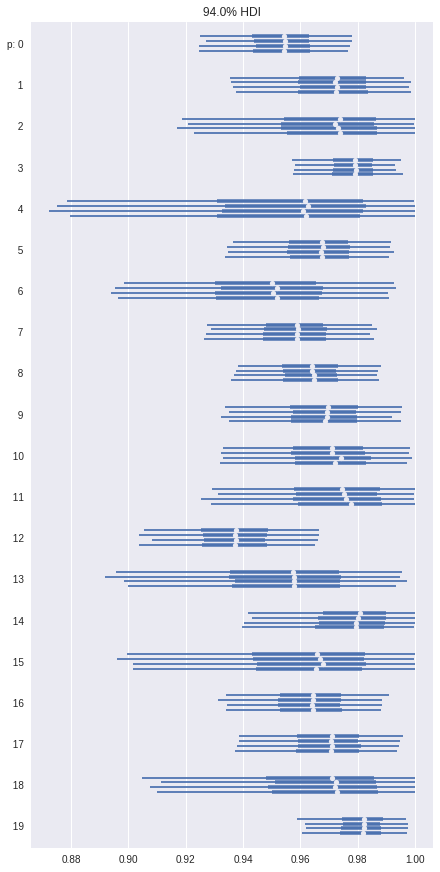

In [97]:
az.plot_trace(trace_bern_hier.posterior[['alpha','beta']]);
az.plot_trace(trace_bern_hier.posterior['p']); 
az.plot_forest(trace_bern_hier.posterior['p'][:,:,0:20]) ;
print('The posteriors of alpha and beta suggest that Junior referees have a lower average and a higher variance.')

Recall that the averate of a beta stable distribution is $\alpha/(\alpha+\beta)$ and the variance is $\alpha\beta/((\alpha+\beta)^2(\alpha+\beta+1))$. So we sample from the the posterior distribution of $\alpha$ and $\beta$ to estimate the mean and variance with the formulae above.


In [109]:
with mod_bern_hier:
    prior_checks_bern_hier = pm.sample_prior_predictive(samples=chains*(n_tune+n_samples))
    ppc_bern_hier_alp = pm.sample_posterior_predictive(trace_bern_hier, 
                                var_names=['alpha'], samples=chains*(n_tune+n_samples), random_seed=seed)
    ppc_bern_hier_beta = pm.sample_posterior_predictive(trace_bern_hier, 
                                var_names=['beta'], samples=chains*(n_tune+n_samples), random_seed=seed)


In [101]:
means, var = [], []
for i in range(len(ppc_bern_hier_alp['alpha'][0,:])):
    m = ppc_bern_hier_alp['alpha'][:,i]/(ppc_bern_hier_alp['alpha'][:,i]+ppc_bern_hier_beta['beta'][:,i])
    v = (ppc_bern_hier_alp['alpha'][:,i]*ppc_bern_hier_beta['beta'][:,i])/(((ppc_bern_hier_alp['alpha'][:,i]+ppc_bern_hier_beta['beta'][:,i])**2)*(ppc_bern_hier_alp['alpha'][:,i]+ppc_bern_hier_beta['beta'][:,i] +1))
    means.append(m.mean())
    var.append(v.mean())

In [111]:
print('Under hierarchical beta-Bernoulli model:')
print('Means of Junior, Mid and Seniors:',means)
print('Stds of Junior, Mid and Seniors:',var)

Under hierarchical beta-Bernoulli model:
Means of Junior, Mid and Seniors: [0.9476653177689899, 0.9549189364354349, 0.9555233920578319]
Stds of Junior, Mid and Seniors: [0.0017446759640081307, 0.0012039255524402695, 0.0011677741759999294]


Note that the variance of the beta distribution for:
- a Junior referee is 49% higher than a Senior referee. 
- a Junior referee is 45% higher than a Mid referee.
- a Mid referee is 3% higher than a Senior referee.

Meanwhile the means are negligibly close but too low with respect to the global mean which is above 96%, most likely do to shrinkage due to .

# Logit Models

## Hierarchical Normal logit
We now assume that the log-odds-ratio of $p_k$ is normal distributed as $\eta_k $. First we pool the referees in our three experience chategories. This model can then be written as 
$$
p_k = \text{sigmoid}(\eta_k)=\frac{1}{1+e^{-\eta_k}}\quad \text{with}\quad\eta_k\sim N(\mu_{j(k)},\sigma_{j(k)}), 
$$
where $j(k)\in\{0,1,2\}$ according to the experience of the referee $k$ (0 for Junior, 1 for Mid and 2 for Senior).

In [113]:
with pm.Model() as log_norm_hier:
    #priors
    eta = pm.Normal('eta', mu= 2,sigma=1 ,shape=3)
    #Deterministic
    p = pm.Deterministic('p',tt.nnet.sigmoid(eta[obs_ref_class])) 
    #Likelihood
    y = pm.Bernoulli('y', p[idx], observed=observed_calls)

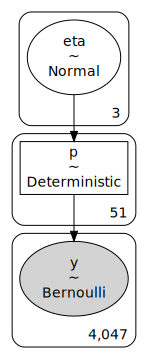

In [114]:
pm.model_to_graphviz(log_norm_hier)

In [115]:
trace_log_norm_hier = sample(log_norm_hier, n_tune, n_samples, seed, chains) 

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [eta]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 7 seconds.


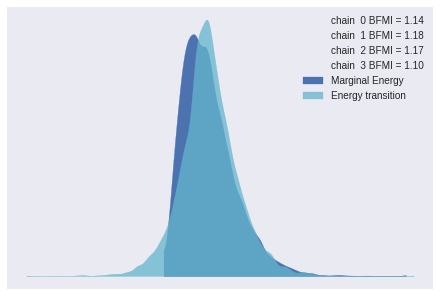

In [36]:
az.plot_energy(trace_log_norm_hier);

array([<AxesSubplot:title={'center':'94.0% HDI'}>], dtype=object)

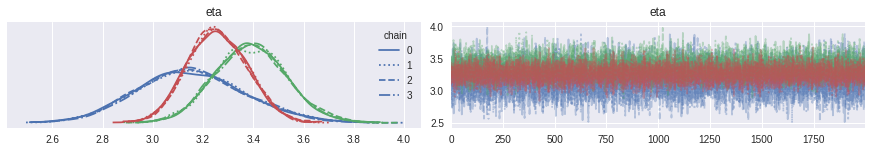

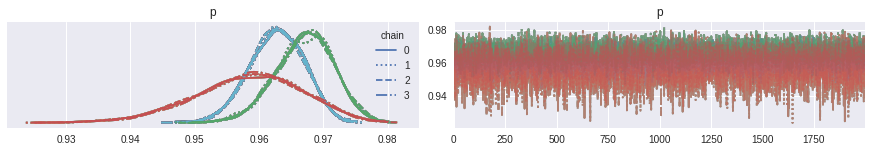

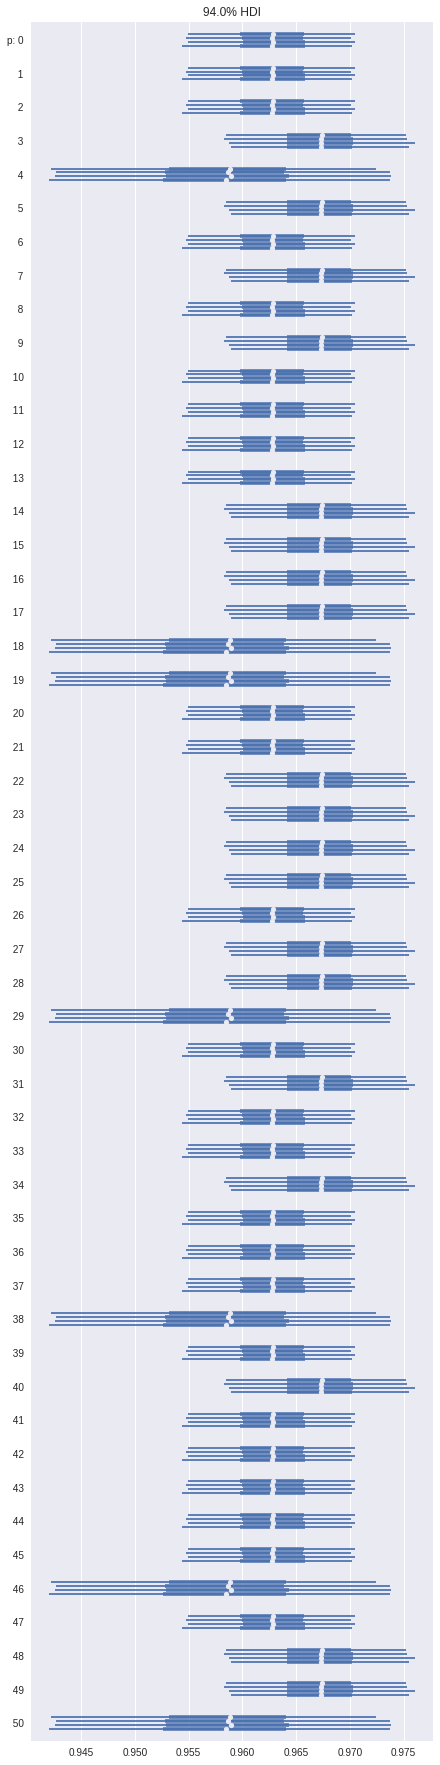

In [116]:
az.plot_trace(trace_log_norm_hier.posterior[['eta']]);
az.plot_trace(trace_log_norm_hier.posterior['p']); 
az.plot_forest(trace_log_norm_hier.posterior['p']);

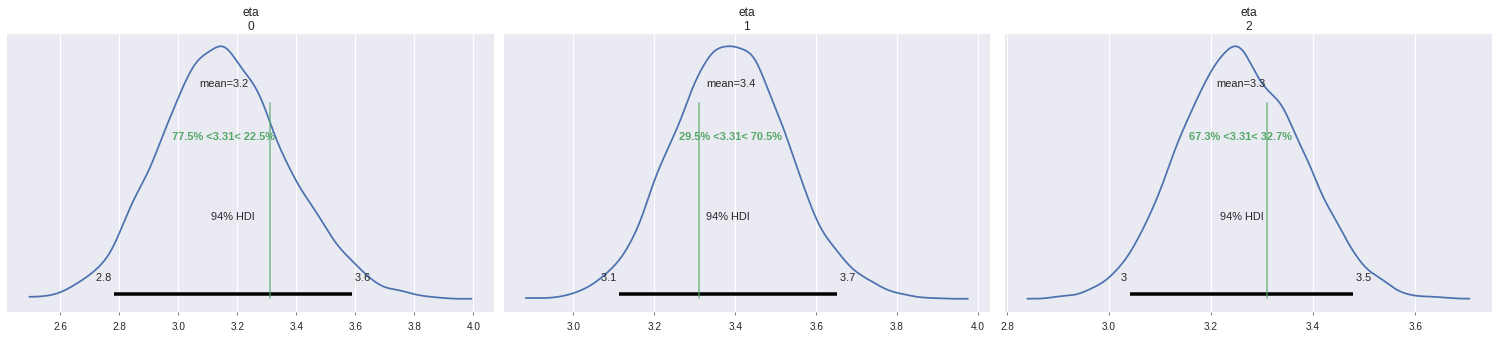

In [118]:
pm.plot_posterior(trace_log_norm_hier, ['eta'], ref_val = round(np.log(mu_cc/(1-mu_cc)),2));
#pm.plot_posterior(trace_log_norm_hier, ['p'], ref_val = mu_cc);

### Posterior checks
We generate posterior predictive on behaviour of J, M, and S to estimate the uncertainty on $p_k$ under this pooled model, and then compare to beta-Bernoulli model.

In [119]:
with log_norm_hier:
    ppc_log_norm_hier_eta = (pm.sample_posterior_predictive(trace_log_norm_hier, var_names=['eta'],
                                                           samples=chains*(n_tune+n_samples), random_seed=seed))

In [143]:
#pl = az.from_pymc3(posterior_predictive=ppc_log_norm_hier_eta, model=log_norm_hier)
#az.plot_ppc(pl)

In [144]:
means, var = [], []
for i in range(len(ppc_log_norm_hier_eta['eta'][0,:])):
    p_ = 1/(1+np.exp(-ppc_log_norm_hier_eta['eta'][:,i]))
    means.append(p_.mean())
    var.append(p_.std())

In [145]:
print('Under hierarchical logit model:')
print('Means of Junior, Mid and Seniors:',means)
print('Stds of Junior, Mid and Seniors:',var)

Under hierarchical logit model:
Means of Junior, Mid and Seniors: [0.958232779643626, 0.9670641268339334, 0.9627127322952813]
Stds of Junior, Mid and Seniors: [0.008492049059406577, 0.004551791072271291, 0.004227854866882669]


Note that the standard deviation of the probability of making a call that is correct for:
- a Junior referee is 87% higher than a Mid referee. 
- a Junion referee is 100% higher than a Senior referee.
- a Mid referee is 8% higher than a Senior referee.

Meanwhile the means are negligibly close and in line with the global mean which is above 96%.

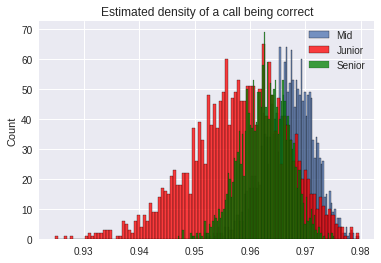

In [126]:
#sns.kdeplot(trace_log_norm_hier.posterior['p'][0,:,3] , bw_method = 1 , fill = True)
fig,ax = plt.subplots()
sns.histplot(trace_log_norm_hier.posterior['p'][0,:,3], ax =ax,bins=100, label='Mid')
sns.histplot(trace_log_norm_hier.posterior['p'][0,:,19], ax =ax, color ='red',bins=100, label='Junior')
sns.histplot(trace_log_norm_hier.posterior['p'][0,:,0], ax =ax, color ='green', bins=100, label='Senior')
ax.set_title('Estimated density of a call being correct')
ax.legend()
plt.show()

## Logit with partial pooling
We now keep assuming that the log-odds-ratio of $p_k$ is normally distributed as some $\eta_k $. But we before we  pooled the referees in our three experience chategories. This model instead partially pooles the referees with respect to experience, but also allows for their independent personal randomness. We do so by solving 
$$
p_k=\frac{1}{1+e^{-\eta_k}}\quad \text{with}\quad\eta_k = N(\mu_{k},\sigma_{k}) + N(\mu_{j(k)},\sigma_{j(k)})\sim N\Big(\mu_{k} + \mu_{j(k)},\sigma_{k}+\sigma_{j(k)}\Big)  ,
$$


where $j(k)\in\{0,1,2\}$ according to the experience of the referee $k$ (0 for Junior, 1 for Mid and 2 for Senior).

In [154]:
with pm.Model() as log_norm_hier_ki:
    #Priors
    eta_exp = pm.Normal('eta_exp', mu=3, sigma=.01 ,shape=3)
    eta_p = pm.Normal('eta_p',mu=0, sigma=.01 , shape=len(obs_ref_class))
    #Deterministic
    p = pm.Deterministic('p',tt.nnet.sigmoid(eta_exp[obs_ref_class]+eta_p)) 
    #Lilkelihood
    y = pm.Bernoulli('y', p[idx], observed=observed_calls)

In [155]:
trace_log_norm_hier_ki = sample(log_norm_hier_ki, n_tune, n_samples, seed, chains)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [eta_p, eta_exp]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 17 seconds.


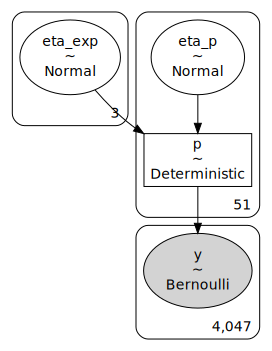

In [149]:
pm.model_to_graphviz(log_norm_hier_ki)

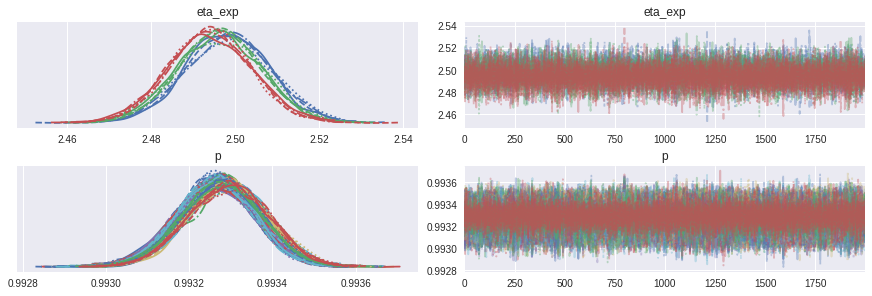

In [153]:
az.plot_trace(trace_log_norm_hier_ki, var_names = ['eta_exp']);

## Logit with linear response to experience model

We include a linear response to referee's experience in the logit model by asusming 

$$
p_k =\frac{1}{1+e^{-\eta_k}}, \quad\text{where}\quad \eta_k\sim N(0,\sigma_k) +b_0+b_1x_k,
$$

with hyperpriors

$$
\mu_k\sim N(0,.1),\,\sigma_k\sim \text{HalfCauchy}(1), \,b_0\sim N(3,.1),\,b_1\sim N(0,.1),
$$

where $x_k$ is the years of experience of referee $k$.

So the estimated slope $b_1$ is supposed to quantify the change in mean and variance of the distribution of $p_k$ as a function of experience. We keep the variances of the priors small to avoid the HMC getting trapped in flat areas of the posterior (due to several referee' 100% correct call rate).

In [180]:
ref_years = []
for id in obs_ref_class:
    ref_years.append(df_ref_c.loc[df_ref_c.ref_1_idx == id].ref_exp.values[0])
np.array(ref_years);

with pm.Model() as log_norm_hier_slop:
    b_0 = pm.Normal('b_0', 3,.1)
    b_1 = pm.Normal('b_1', mu=0, sigma=.1)
    eta_p = pm.Normal('eta_p',mu= 0, sigma=.1 , shape=len(obs_ref_class)) #sig=.01 gives 2 sets
    p = pm.Deterministic('p',tt.nnet.sigmoid(eta_p +b_0+b_1*ref_years)) 
    y = pm.Bernoulli('y', p[idx], observed=observed_calls)

In [181]:
trace_log_norm_hier_slop = sample(log_norm_hier_slop, n_tune, n_samples, seed, chains)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [eta_p, b_1, b_0]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 22 seconds.


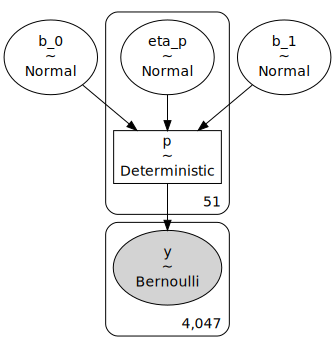

In [182]:
pm.model_to_graphviz(log_norm_hier_slop)

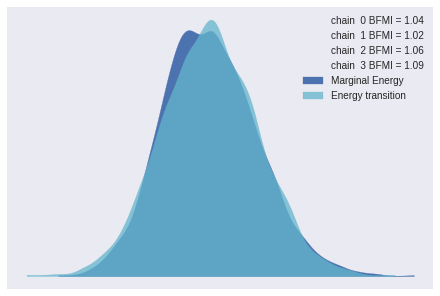

In [183]:
az.plot_energy(trace_log_norm_hier_slop);

Note that the current model suggest a smooth transition between experience levels. 

First 30 referees posterior distributions.
Below the posteriors for Junior ref. J. Capers (id=19) and Senior ref. J. Phillips (id=20).


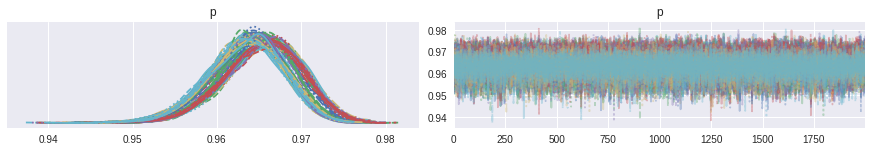

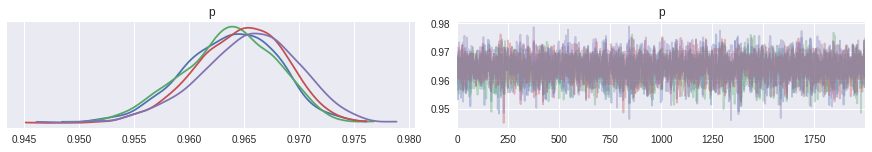

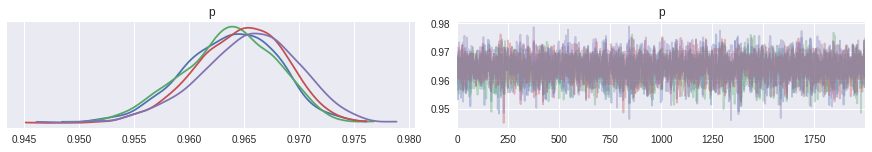

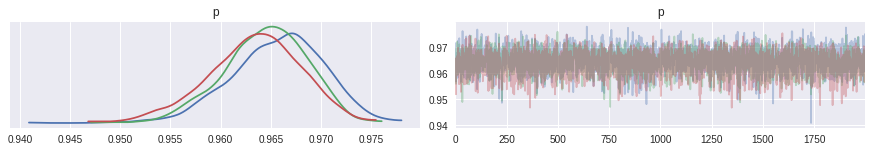

In [184]:
print('First 30 referees posterior distributions.')
print('Below the posteriors for Junior ref. J. Capers (id=19) and Senior ref. J. Phillips (id=20).')
az.plot_trace(trace_log_norm_hier_slop.posterior['p'][:,:,0:30]);
az.plot_trace(trace_log_norm_hier_slop.posterior['p'][0:1,:,17:21]);
az.plot_trace(trace_log_norm_hier_slop.posterior['p'][0:1,:,17:21]);
az.plot_trace(trace_log_norm_hier_slop.posterior['p'][0:1,:,2:5]);

### Change of priors
Let us show that if we change the prior `eta_p` variance from 0.1 to 0.01, the model, instead, suggests a classification in two groups, which is a conclusion supported from the previous logit model. One could interpret this as diminishing the importance that we want to give to individuals variances.

In [185]:
ref_years = []
for id in obs_ref_class:
    ref_years.append(df_ref_c.loc[df_ref_c.ref_1_idx == id].ref_exp.values[0])
np.array(ref_years);

with pm.Model() as log_norm_hier_slop_change_pri:
    b_0 = pm.Normal('b_0', 3,.1)
    b_1 = pm.Normal('b_1', mu=0, sigma=.1)
    eta_p = pm.Normal('eta_p',mu= 0, sigma=.05 , shape=len(obs_ref_class)) #sig=.01 gives 2 sets
    p = pm.Deterministic('p',tt.nnet.sigmoid(eta_p +b_0+b_1*ref_years)) 
    y = pm.Bernoulli('y', p[idx], observed=observed_calls)

In [186]:
trace_log_norm_hier_slop_change_pri = sample(log_norm_hier_slop_change_pri, n_tune, n_samples, seed, chains)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [eta_p, b_1, b_0]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 19 seconds.


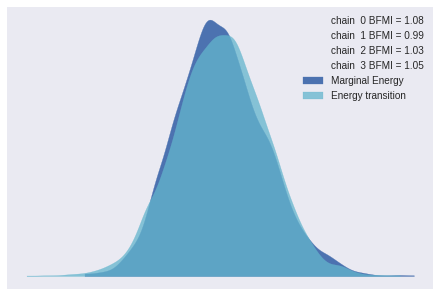

In [187]:
az.plot_energy(trace_log_norm_hier_slop_change_pri);

Note that the current model suggest a smooth transition between experience levels. Let us mention that if we change prior `eta_p` variance from $0.1$ to $0.01$, the model suggest a classification in two groups, which is consistent with Junior as a conclusion supported from the previous logit model.

First 30 referees posterior distributions.
Below the posteriors for Junior ref. J. Capers (id=19) and Senior ref. J. Phillips (id=20).


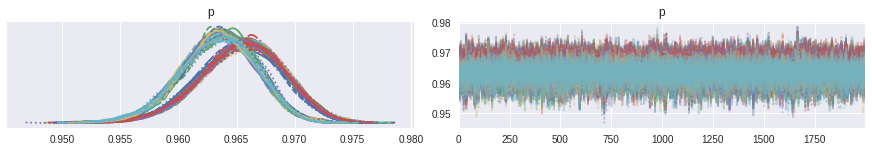

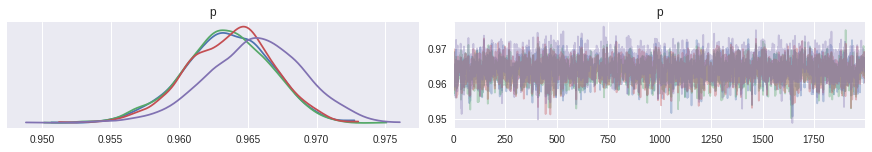

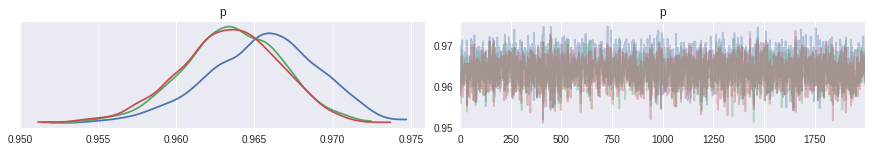

In [188]:
print('First 30 referees posterior distributions.')
print('Below the posteriors for Junior ref. J. Capers (id=19) and Senior ref. J. Phillips (id=20).')
az.plot_trace(trace_log_norm_hier_slop_change_pri.posterior['p'][:,:,0:30]);
az.plot_trace(trace_log_norm_hier_slop_change_pri.posterior['p'][0:1,:,17:21]);
az.plot_trace(trace_log_norm_hier_slop_change_pri.posterior['p'][0:1,:,2:5]);